In [1]:
import os

import numpy as np
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import numpy_indexed as npi
from scipy.io import loadmat

from src.ipm import NeuronLoader, grablabels
from src.metrics import sepind

from imblearn.under_sampling import RandomUnderSampler as rus
from scipy.ndimage import gaussian_filter1d as smooth

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, roc_auc_score
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split as tts
from sklearn.metrics import recall_score

In [2]:
fontsize = 28
titlefontsize = 36
make_smooth = True
sns.set_palette("Set2")

# Ordinal

## Functions

In [ ]:
def mkeqdata(data, groups, n, seed=0):
    np.random.seed(seed)
    ind0 = np.random.choice(np.argwhere(groups==0).squeeze(), size=n, replace=False)
    ind1 = np.random.choice(np.argwhere(groups==1).squeeze(), size=n, replace=False)
    
    X = np.concatenate([data[ind0], data[ind1]], axis=0)
    y = np.concatenate([np.zeros_like(ind0), np.ones_like(ind1)])
    return X, y

In [ ]:
def initmetric(nmb_bin, nmb_rep):
    cfn = np.nan * np.ones([2, 2, nmb_bin, nmb_rep])
    dth = np.nan * np.ones([nmb_bin, nmb_rep])
    dpr = np.nan * np.ones([nmb_bin, nmb_rep])
    auc = np.nan * np.ones([nmb_bin, nmb_rep])
    return cfn, dth, dpr, auc

In [ ]:
def calcmetric(mdl, X_test, y_test):
    y_pred = mdl.predict(X_test)
    y_prob = mdl.predict_proba(X_test)
    dist = mdl['svc'].decision_function(X_test) / np.linalg.norm(mdl['svc'].coef_)
    d0, d1 = dist[y_test==0], dist[y_test==1]
    
    cfn = confusion_matrix(y_test, y_pred, labels=[0, 1], sample_weight=None, normalize=None)
    dth = np.abs(d0.mean() - d1.mean())
    dpr = np.sqrt(2) * np.abs(d0.mean() - d1.mean()) / np.sqrt(d0.var() + d1.var())
    auc = roc_auc_score(y_test, y_prob[:, 1])
    
    return cfn, dth, dpr, auc

In [ ]:
def savemetric(path: str, prefix: str, cfn: np.array, dth: np.array, dpr: np.array, auc: np.array) -> None:
    np.save(os.path.join(path, prefix + '-cfn.npy'), cfn)
    np.save(os.path.join(path, prefix + '-dth.npy'), dth)
    np.save(os.path.join(path, prefix + '-dpr.npy'), dpr)
    np.save(os.path.join(path, prefix + '-auc.npy'), auc)

In [ ]:
nmb_component = .95
nmb_rep = 200

for monkey in ["both"]:
    for selectivity in ["fast"]:
        data = NeuronLoader(f'G:/Data/{selectivity.capitalize()}/{monkey.capitalize()}')
        out_path  = f'G:\\Codes\\Processing\\out\\svm\\{monkey.lower()}-{selectivity.lower()}'
        os.makedirs(out_path, exist_ok=True)
        
        for region in ['it', 'pfc']:
            region_data = data.it if region=='it' else data.pfc

            for categ in ['super-ordinate', 'mid-level']:
                nmb_bin = data.it.shape[2]
                cfn, dth, dpr, auc = initmetric(nmb_bin, nmb_rep)
                
                yc = grablabels(hierarchy=categ)
                nmb_sample = np.min([(yc==0).sum(), (yc==1).sum()])

                for seed in (pbar := tqdm(range(nmb_rep))):
                    pbar.set_description(monkey+"-"+selectivity+"-"+region+"-"+categ)
                    X, y = mkeqdata(region_data, yc, nmb_sample, seed=seed)

                    for ibin in range(data.it.shape[2]):
                        pca = PCA(n_components=None if nmb_component==-1 else nmb_component, 
                                  copy=True, whiten=False, svd_solver='auto', random_state=seed)
                        Xr = pca.fit_transform(X[:,:,ibin])
                        X_train, X_test, y_train, y_test = tts(Xr, y, test_size=.3,
                                                               random_state=seed, shuffle=True, stratify=y)
                        mdl = make_pipeline(StandardScaler(), SVC(C=2.4, probability=True, kernel='linear', 
                                                                  random_state=seed)).fit(X_train, y_train)
                        
                        cfn[:,:,ibin,seed], dth[ibin,seed], dpr[ibin,seed], auc[ibin,seed] = calcmetric(mdl, X_test, y_test)
                
                savemetric(out_path, region.lower() + "-" + categ, cfn, dth, dpr, auc)

## Calculate the Metrics for All Parts of Data

In [ ]:
nmb_component = .95
nmb_rep = 200

for monkey in ["jenab", "zebel", "both"]:
    for selectivity in ["fast", "slow"]:
        data = NeuronLoader(f'G:/Data/{selectivity.capitalize()}/{monkey.capitalize()}')
        out_path  = f'G:\\Codes\\Processing\\out\\svm\\{monkey.lower()}-{selectivity.lower()}'
        os.makedirs(out_path, exist_ok=True)
        
        for region in ['it', 'pfc']:
            region_data = data.it if region=='it' else data.pfc

            for categ in ['super-ordinate', 'mid-level']:
                print(monkey+"-"+selectivity+"-"+region+"-"+categ)
                nmb_bin = data.it.shape[2]
                cfn, dth, dpr, auc = initmetric(nmb_bin, nmb_rep)
                
                yc = grablabels(hierarchy=categ)
                nmb_sample = np.min([(yc==0).sum(), (yc==1).sum()])

                for seed in range(nmb_rep):
                    X, y = mkeqdata(region_data, yc, nmb_sample, seed=seed)

                    for ibin in range(data.it.shape[2]):
                        pca = PCA(n_components=None if nmb_component==-1 else nmb_component, 
                                  copy=True, whiten=False, svd_solver='auto', random_state=seed)
                        Xr = pca.fit_transform(X[:,:,ibin])
                        X_train, X_test, y_train, y_test = tts(Xr, y, test_size=.3,
                                                               random_state=seed, shuffle=True, stratify=y)
                        mdl = make_pipeline(StandardScaler(), SVC(C=2.4, probability=True, kernel='linear', 
                                                                  random_state=seed)).fit(X_train, y_train)
                        
                        cfn[:,:,ibin,seed], dth[ibin,seed], dpr[ibin,seed], auc[ibin,seed] = calcmetric(mdl, X_test, y_test)
                
                savemetric(out_path, region.lower() + "-" + categ, cfn, dth, dpr, auc)

In [ ]:
os.path.join(out_path, f"{region}-{statistic}.jpg")
region

In [ ]:
monkey = 'both'
selectivity = 'fast'
region = 'it'

# for statistic in ['dth', 'dpr', 'auc']:
#     out_path = f"G:\\Codes\\Processing\\out\\svm\\{monkey.lower()}-{selectivity.lower()}"
#     data = NeuronLoader(f'G:/Data/{selectivity.capitalize()}/{monkey.capitalize()}')

#     fig, axs = plt.subplots(1, 2, figsize=np.array([32, 9]), dpi=50)
#     sns.despine()

#     for iregion, (ax, region) in enumerate(zip(axs, ["it", "pfc"])):
#         ml = np.load(os.path.join(out_path, f'{region.lower()}-mid-level-{statistic}.npy'))
#         so = np.load(os.path.join(out_path, f'{region.lower()}-super-ordinate-{statistic}.npy'))

#         for metric, va in zip([so, ml], ["top", "bottom"]):
#             metric = metric if not make_smooth else np.transpose(smooth(np.transpose(metric), sigma=3))
#             anot = metric.mean(1).max()
#             metric /= np.array([so.mean(1), ml.mean(1)]).max()
#             metric -= metric[(data.time > -50) & (data.time <= 0), :].mean()
#             ax.plot(data.time, metric.mean(1), lw=5)
#             ax.fill_between(data.time, metric.mean(1) + metric.std(1), metric.mean(1) - metric.std(1), label='_nolegend_', alpha=.25)
#             ax.annotate(f"{int(data.time[metric.mean(1).argmax()])}, {anot:.1f}", 
#                         xy=(data.time[metric.mean(1).argmax()], metric.mean(1).max()), 
#                         xycoords='data', fontsize=18, 
#                         horizontalalignment='center',
#                         verticalalignment=va)
#         ax.set_title(region.upper(), fontsize=fontsize)    
#         ax.legend(["Super-Ordinate", "Mid-Level"], frameon=False, fontsize=fontsize)
#         ax.axvline(x=0, color='tab:gray', linestyle='dashed', label='_nolegend_')
#         ax.axvline(x=50 if selectivity=="fast" else 250, color='tab:gray', linestyle='dashed', label='_nolegend_')    
#         ax.set_xlim(-50, 550)
#         ax.set_xlabel('time (ms)', fontsize=fontsize)
#         ax.tick_params(axis='both', which='major', labelsize=fontsize)

#     if statistic == 'dth':
#         fig.suptitle(f'Absolute Difference of Mean Distances from SVM\'s Hyperplane', fontsize=titlefontsize)
#         axs[0].set_ylabel(r'$\sqrt{2} \times |\mu_1-\mu_2|}$', fontsize=fontsize)
#     elif statistic == 'dpr':
#         fig.suptitle(f"d' of Distances from SVM\'s Hyperplane", fontsize=titlefontsize)
#         axs[0].set_ylabel(r'$\frac{\sqrt{2} \times |\mu_1-\mu_2|}{\sqrt{\sigma_1^2+\sigma_2^2}} $', fontsize=fontsize)
#     elif statistic == 'auc':
#         fig.suptitle(f'Area under Receptive-Operating Curve', fontsize=titlefontsize)
#         axs[0].set_ylabel(r'$S_{ROC}$', fontsize=fontsize)

#     fig.tight_layout()
#     # fig.savefig(os.path.join(out_path, f"{statistic}.eps"), format='eps')
#     fig.savefig(os.path.join(out_path, f"{statistic}.jpg"), dpi=600)

statistic = 'cfn'
out_path = f"G:\\Codes\\Processing\\out\\svm\\{monkey.lower()}-{selectivity.lower()}"

fig, axs = plt.subplots(1, 2, figsize=np.array([32, 9]), dpi=50)
sns.despine()

for iregion, (ax, region) in enumerate(zip(axs, ["it", "pfc"])):
    ml = np.load(os.path.join(out_path, f'{region.lower()}-mid-level-{statistic}.npy'))
    so = np.load(os.path.join(out_path, f'{region.lower()}-super-ordinate-{statistic}.npy'))

    ml = np.trace(ml, axis1=0, axis2=1) / ml.sum((0, 1))
    so = np.trace(so, axis1=0, axis2=1) / so.sum((0, 1))

    for metric, va in zip([so, ml], ["top", "bottom"]):
        metric = metric if not make_smooth else np.transpose(smooth(np.transpose(metric), sigma=10))
        # anot = metric.mean(1).max()
        # metric /= np.array([so.mean(1), ml.mean(1)]).max()
        # metric -= metric[(data.time > -50) & (data.time <= 0), :].mean()
        ax.plot(data.time, metric.mean(1), lw=5)
        ax.fill_between(data.time, metric.mean(1) + metric.std(1), metric.mean(1) - metric.std(1), label='_nolegend_', alpha=.25)
        # ax.annotate(f"{int(data.time[metric.mean(1).argmax()])}, {anot:.1f}", 
        #             xy=(data.time[metric.mean(1).argmax()], metric.mean(1).max()), 
        #             xycoords='data', fontsize=18, 
        #             horizontalalignment='center',
        #             verticalalignment=va)
    ax.set_title(region.upper(), fontsize=fontsize)    
    ax.legend(["Super-Ordinate", "Mid-Level"], frameon=False, fontsize=fontsize)
    ax.axvline(x=0, color='tab:gray', linestyle='dashed', label='_nolegend_')
    ax.axvline(x=50 if selectivity=="fast" else 250, color='tab:gray', linestyle='dashed', label='_nolegend_')    
    ax.set_xlim(-50, 550)
    ax.set_xlabel('time (ms)', fontsize=fontsize)
    ax.tick_params(axis='both', which='major', labelsize=fontsize)

fig.suptitle(f'Decoder Accuracy', fontsize=titlefontsize)
axs[0].set_ylabel(r'CCR (ratio)', fontsize=fontsize)

fig.tight_layout()
# fig.savefig(os.path.join(out_path, f"{statistic}.eps"), format='eps')
fig.savefig(os.path.join(out_path, f"{statistic}.jpg"), dpi=600)

In [ ]:
for monkey in ['zebel', 'jenab', 'both']:
    for selectivity in ['fast', 'slow']:
        for statistic in ['dth', 'dpr', 'auc']:
            out_path = f"G:\\Codes\\Processing\\out\\svm\\{monkey.lower()}-{selectivity.lower()}"
            data = NeuronLoader(f'G:/Data/{selectivity.capitalize()}/{monkey.capitalize()}')

            fig, axs = plt.subplots(1, 2, figsize=np.array([32, 9]), dpi=50)
            sns.despine()

            for iregion, (ax, region) in enumerate(zip(axs, ["it", "pfc"])):
                ml = np.load(os.path.join(out_path, f'{region.lower()}-mid-level-{statistic}.npy'))
                so = np.load(os.path.join(out_path, f'{region.lower()}-super-ordinate-{statistic}.npy'))

                for metric, va in zip([so, ml], ["top", "bottom"]):
                    metric = metric if not make_smooth else np.transpose(smooth(np.transpose(metric), sigma=3))
                    anot = metric.mean(1).max()
                    metric /= np.array([so.mean(1), ml.mean(1)]).max()
                    metric -= metric[(data.time > -50) & (data.time <= 0), :].mean()
                    ax.plot(data.time, metric.mean(1), lw=5)
                    ax.fill_between(data.time, metric.mean(1) + metric.std(1), metric.mean(1) - metric.std(1), label='_nolegend_', alpha=.25)
                    ax.annotate(f"{int(data.time[metric.mean(1).argmax()])}, {anot:.1f}", 
                                xy=(data.time[metric.mean(1).argmax()], metric.mean(1).max()), 
                                xycoords='data', fontsize=18, 
                                horizontalalignment='center',
                                verticalalignment=va)
                ax.set_title(region.upper(), fontsize=fontsize)    
                ax.legend(["Super-Ordinate", "Mid-Level"], frameon=False, fontsize=fontsize)
                ax.axvline(x=0, color='tab:gray', linestyle='dashed', label='_nolegend_')
                ax.axvline(x=50 if selectivity=="fast" else 250, color='tab:gray', linestyle='dashed', label='_nolegend_')    
                ax.set_xlim(-50, 550)
                ax.set_xlabel('time (ms)', fontsize=fontsize)
                ax.tick_params(axis='both', which='major', labelsize=fontsize)

            if statistic == 'dth':
                fig.suptitle(f'Absolute Difference of Mean Distances from SVM\'s Hyperplane in {region.upper()}', fontsize=titlefontsize)
                axs[0].set_ylabel(r'$\sqrt{2} \times |\mu_1-\mu_2|}$', fontsize=fontsize)
            elif statistic == 'dpr':
                fig.suptitle(f"d' of Distances from SVM\'s Hyperplane in {region.upper()}", fontsize=titlefontsize)
                axs[0].set_ylabel(r'$\frac{\sqrt{2} \times |\mu_1-\mu_2|}{\sqrt{\sigma_1^2+\sigma_2^2}} $', fontsize=fontsize)
            elif statistic == 'auc':
                fig.suptitle(f'Area under Receptive-Operating Curve in {region.upper()}', fontsize=titlefontsize)
                axs[0].set_ylabel(r'$S_{ROC}$', fontsize=fontsize)

            fig.tight_layout()
            fig.savefig(os.path.join(out_path, f"{statistic}.eps"), format='eps')
            fig.savefig(os.path.join(out_path, f"{statistic}.jpg"))

In [ ]:
metric[(data.time > -50) & (data.time <= 0), :].mean()

In [ ]:
f'G:/Data/{selectivity.capitalize()}/{monkey.capitalize()}'

## Jenab - Slow

In [ ]:
for region in ['it', 'pfc']:
    region_data = data.it if region=='it' else data.pfc

    for categ in ['super-ordinate', 'mid-level']: 
        confusion = np.nan * np.ones([2, 2, data.it.shape[2], nmb_rep])
        dth = np.nan * np.ones([data.it.shape[2], nmb_rep])
        dpr = np.nan * np.ones([data.it.shape[2], nmb_rep])
        auc = np.nan * np.ones([data.it.shape[2], nmb_rep])
        yc = grablabels(hierarchy=categ)
        nmb_sample = np.min([(yc==0).sum(), (yc==1).sum()])

        for seed in tqdm(range(nmb_rep)):
            X, y = mkeqdata(region_data, yc, nmb_sample, seed=seed)

            for ibin in range(data.it.shape[2]):
                pca = PCA(n_components=None if nmb_component==-1 else nmb_component, copy=True, whiten=False, svd_solver='auto', random_state=seed)
                Xr = pca.fit_transform(X[:,:,ibin])
                X_train, X_test, y_train, y_test = train_test_split(Xr, y, test_size=.3,
                                                                    random_state=seed, shuffle=True, stratify=y)
                mdl = make_pipeline(StandardScaler(), SVC(C=2.4, probability=True, kernel='linear', random_state=seed)).fit(X_train, y_train)
                y_pred = mdl.predict(X_test)
                y_prob = mdl.predict_proba(X_test)

                confusion[:, :, ibin, seed] = confusion_matrix(y_test, y_pred, labels=[0, 1], sample_weight=None, normalize=None)
                dist = mdl.decision_function(X_test) / np.linalg.norm(mdl['svc'].coef_)
                d0, d1 = dist[y_test==0], dist[y_test==1]
                dth[ibin, seed] = np.abs(d0.mean() - d1.mean())
                dpr[ibin, seed] = np.sqrt(2) * np.abs(d0.mean() - d1.mean()) / np.sqrt(d0.var() + d1.var())
                auc[ibin, seed] = roc_auc_score(y_test, y_prob[:, 1])

        np.save(os.path.join(out_path, region.lower() + "-" + categ + '-cm.npy'), confusion)
        np.save(os.path.join(out_path, region.lower() + "-" + categ + '-dth.npy'), dth)
        np.save(os.path.join(out_path, region.lower() + "-" + categ + '-dpr.npy'), dpr)
        np.save(os.path.join(out_path, region.lower() + "-" + categ + '-auc.npy'), auc)

In [ ]:
out_path

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=np.array([32, 9]), dpi=50)
sns.despine()

for iregion, region in enumerate(["it", "pfc"]):
    ml = np.load(os.path.join(out_path, f'{region.lower()}-mid-level-dpr.npy'))
    so = np.load(os.path.join(out_path, f'{region.lower()}-super-ordinate-dth.npy'))
    
    for metric in [so, ml]:
        metric = metric if not make_smooth else np.transpose(smooth(np.transpose(metric), sigma=3))
        axs[iregion].plot(data.time, metric.mean(1), lw=5)
        axs[iregion].fill_between(data.time, metric.mean(1) + metric.std(1), metric.mean(1) - metric.std(1), label='_nolegend_', alpha=.25)

for ax in axs:
    ax.axvline(x=0, color='tab:gray', linestyle='dashed', label='_nolegend_')
    ax.axvline(x=50, color='tab:gray', linestyle='dashed', label='_nolegend_')    
    ax.axvline(x=250, color='tab:gray', linestyle='dashed', label='_nolegend_')
    ax.legend(["Super-Ordinate", "Mid-Level"], frameon=False, fontsize=fontsize)
    ax.set_xlim(-50, 400)
    ax.set_title(f'Distance from SVM\'s Hyperplane in {region.upper()}', fontsize=titlefontsize)
    ax.set_xlabel('time (ms)', fontsize=fontsize)
    ax.set_ylabel(r'$|\frac{1}{n}\sum_{i}d_i - \frac{1}{n}\sum_{j}d_j|$', fontsize=fontsize)
    ax.tick_params(axis='both', which='major', labelsize=fontsize)
    plt.setp(ax.spines.values(), linewidth=2);

# plt.savefig(os.path.join(out_path, f"{region.upper()}-ordinal-dth.png"), dpi=600)
# plt.savefig(os.path.join(out_path, f"{region.upper()}-ordinal-dth.jpg"), dpi=600)

## Zebel - Slow

In [ ]:
class NeuronReader:
    def __init__(self, root, from_file=False):
        self.root = root
        self.sessioninfo = pd.read_csv(os.path.join(root, 'guide.csv'))
        self.from_file = from_file
        self.it = self.load('IT')
        self.pfc = self.load('PFC')
        self.time = np.linspace(-175, 974, self.it.shape[2])

    def load(self, region):
        reg = self.sessioninfo['unit id'].str.split("/").map(lambda x: x[0])
        nunit, nstim = (reg==region.upper()).sum(), 165
        nsample = loadmat(self.sessioninfo['file path'][0])['ua'].shape[1]
        data = np.nan * np.zeros([nstim, nunit, nsample])

        if self.from_file or ~os.path.isfile(os.path.join(self.root, f'{region}.npy')):
            for iunit, fpath in enumerate(self.sessioninfo.loc[reg==region.upper()]['file path']):
                ua = loadmat(fpath)['ua']
                cm = loadmat(os.path.join(os.path.dirname(fpath), 'cm.mat'))['cm']
                if cm.size > ua.shape[0]:
                    cm = cm[:ua.shape[0]]
                for istim in np.arange(1, nstim + 1, 1):
                    data[istim-1, iunit, :] = ua[(cm == istim).squeeze(), :].mean(0)
            out = self.movavg(data, 50, 1)
            np.save(os.path.join(self.root, f'{region}.npy'), out)
        else:
            out = np.load(os.path.join(self.root, f'{region}.npy'))
        return out
    
    def movavg(self, inp, bl, ss):
        nbin = int(np.floor((inp.shape[2] - bl) / ss))
        out = np.nan * np.zeros((inp.shape[0], inp.shape[1], nbin))
        for ibin in range(nbin):
            out[:, :, ibin] = np.sum(inp[:, :, int(ibin*ss):int(ibin*ss)+bl], 2) / bl * 1000
        return out
    
data = NeuronReader(f'G:/Data/Slow/Zebel', from_file=True)

In [ ]:
def mkeqdata(data, groups, n, seed=0):
    np.random.seed(seed)
    ind0 = np.random.choice(np.argwhere(groups==0).squeeze(), size=n, replace=False)
    ind1 = np.random.choice(np.argwhere(groups==1).squeeze(), size=n, replace=False)
    
    X = np.concatenate([data[ind0], data[ind1]], axis=0)
    y = np.concatenate([np.zeros_like(ind0), np.ones_like(ind1)])
    return X, y

In [ ]:
monkey = "zebel"
selectivity = "slow"

out_path  = f'G:\\Codes\\Processing\\out\\svm\\ordinal\\{monkey}-{selectivity}'
os.makedirs(out_path, exist_ok=True)

nmb_component = .95
nmb_rep = 200

In [ ]:
for region in ['it', 'pfc']:
    region_data = data.it if region=='it' else data.pfc

    for categ in ['super-ordinate', 'mid-level']: 
        confusion = np.nan * np.ones([2, 2, data.it.shape[2], nmb_rep])
        dth = np.nan * np.ones([data.it.shape[2], nmb_rep])

        yc = grablabels(hierarchy=categ)
        nmb_sample = np.min([(yc==0).sum(), (yc==1).sum()])

        for seed in tqdm(range(nmb_rep)):
            X, y = mkeqdata(region_data, yc, nmb_sample, seed=seed)

            for ibin in range(data.it.shape[2]):
                pca = PCA(n_components=None if nmb_component==-1 else nmb_component, copy=True, whiten=False, svd_solver='auto', random_state=seed)
                Xr = pca.fit_transform(X[:,:,ibin])
                X_train, X_test, y_train, y_test = train_test_split(Xr, y, test_size=.3,
                                                            random_state=seed, shuffle=True, stratify=y)
                mdl = SVC(C=2.4, kernel='linear', random_state=seed).fit(X_train, y_train)
                y_pred = mdl.predict(X_test)
                confusion[:, :, ibin, seed] = confusion_matrix(y_test, y_pred, labels=[0, 1], sample_weight=None, normalize=None)

                dist = mdl.decision_function(X_test) / np.linalg.norm(mdl.coef_)
                dth[ibin, seed] = np.abs(dist[y_test==0].mean() - dist[y_test==1].mean())
        np.save(os.path.join(out_path, region.lower() + "-" + categ + '-cm.npy'), confusion)
        np.save(os.path.join(out_path, region.lower() + "-" + categ + '-dth.npy'), dth)

In [ ]:
region = 'pfc'

fontsize = 28
titlefontsize = 36
make_smooth = True
sns.set_palette("Set2")

fig, axs = plt.subplots(1, 1, figsize=np.array([16, 9]), dpi=50)

ml = np.load(os.path.join(out_path, f'{region.lower()}-mid-level-dth.npy'))
so = np.load(os.path.join(out_path, f'{region.lower()}-super-ordinate-dth.npy'))

for metric in [so, ml]:
    metric = metric if not make_smooth else np.transpose(smooth(np.transpose(metric), sigma=3))
    plt.plot(data.time, metric.mean(1), lw=5)
    # plt.fill_between(time, np.percentile(acc, 5, axis=1), np.percentile(acc, 95, axis=1), label='_nolegend_', alpha=.25)
    plt.fill_between(data.time, metric.mean(1) + metric.std(1), metric.mean(1) - metric.std(1), label='_nolegend_', alpha=.25)

plt.axvline(x=0, color='tab:gray', linestyle='dashed', label='_nolegend_')
plt.axvline(x=50, color='tab:gray', linestyle='dashed', label='_nolegend_')    
if data.time.size==1150:
    plt.axvline(x=250, color='tab:gray', linestyle='dashed', label='_nolegend_')

sns.despine()
axs.legend(["Super-Ordinate", "Mid-Level"], frameon=False, fontsize=fontsize)
axs.set_xlim(-50, 400)
plt.title(f'Distance from SVM\'s Hyperplane in {region.upper()}', fontsize=titlefontsize)
plt.xlabel('time (ms)', fontsize=fontsize)
plt.ylabel(r'$|\frac{1}{n}\sum_{i}d_i - \frac{1}{n}\sum_{j}d_j|$', fontsize=fontsize)
axs.tick_params(axis='both', which='major', labelsize=fontsize)
plt.setp(axs.spines.values(), linewidth=2);

plt.savefig(os.path.join(out_path, f"{region.upper()}-ordinal-dth.png"), dpi=600)
plt.savefig(os.path.join(out_path, f"{region.upper()}-ordinal-dth.jpg"), dpi=600)

## Jenab - Slow


In [ ]:
from src.ipm import NeuronReader

monkey = "jenab"
selectivity = "slow"

data = NeuronReader(f'G:/Data/{selectivity.capitalize()}/{monkey.capitalize()}', from_file=True)

out_path  = f'G:\\Codes\\Processing\\out\\svm\\ordinal\\{monkey}-{selectivity}'
os.makedirs(out_path, exist_ok=True)

nmb_component = .95
nmb_rep = 200

In [ ]:
for region in ['it', 'pfc']:
    region_data = data.it if region=='it' else data.pfc

    for categ in ['super-ordinate', 'mid-level']: 
        confusion = np.nan * np.ones([2, 2, data.it.shape[2], nmb_rep])
        dth = np.nan * np.ones([data.it.shape[2], nmb_rep])

        yc = grablabels(hierarchy=categ)
        nmb_sample = np.min([(yc==0).sum(), (yc==1).sum()])

        for seed in tqdm(range(nmb_rep)):
            X, y = mkeqdata(region_data, yc, nmb_sample, seed=seed)

            for ibin in range(data.it.shape[2]):
                pca = PCA(n_components=None if nmb_component==-1 else nmb_component, copy=True, whiten=False, svd_solver='auto', random_state=seed)
                Xr = pca.fit_transform(X[:,:,ibin])
                X_train, X_test, y_train, y_test = train_test_split(Xr, y, test_size=.3,
                                                            random_state=seed, shuffle=True, stratify=y)
                mdl = SVC(C=2.4, kernel='linear', random_state=seed).fit(X_train, y_train)
                y_pred = mdl.predict(X_test)
                confusion[:, :, ibin, seed] = confusion_matrix(y_test, y_pred, labels=[0, 1], sample_weight=None, normalize=None)

                dist = mdl.decision_function(X_test) / np.linalg.norm(mdl.coef_)
                dth[ibin, seed] = np.abs(dist[y_test==0].mean() - dist[y_test==1].mean())
        np.save(os.path.join(out_path, region.lower() + "-" + categ + '-cm.npy'), confusion)
        np.save(os.path.join(out_path, region.lower() + "-" + categ + '-dth.npy'), dth)

In [ ]:
plt.plot(data.time, dpr[:, 0])
# plt.plot(auc[:, 0])
dist_0.std()

In [ ]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y, y_pred)

In [ ]:
y_pred

In [ ]:
monkey = "jenab"
selectivity = "fast"

data_path = f'G:\\Data\\{selectivity.capitalize()}\\{monkey.capitalize()}'
out_path  = f'G:\\Codes\\Processing\\out\\svm\\ordinal\\{monkey}-{selectivity}'

nmb_component = .95
nmb_rep = 200

In [ ]:
data = NeuronReader(data_path)

In [ ]:
def mkeqdata(data, groups, n, seed=0):
    np.random.seed(seed)
    ind0 = np.random.choice(np.argwhere(groups==0).squeeze(), size=n, replace=False)
    ind1 = np.random.choice(np.argwhere(groups==1).squeeze(), size=n, replace=False)
    
    X = np.concatenate([data[ind0], data[ind1]], axis=0)
    y = np.concatenate([np.zeros_like(ind0), np.ones_like(ind1)])
    return X, y

In [ ]:
for region in ['it', 'pfc']:
    region_data = data.it if region=='it' else data.pfc

    for categ in ['super-ordinate', 'mid-level']: 
        confusion = np.nan * np.ones([2, 2, data.it.shape[2], nmb_rep])
        dth = np.nan * np.ones([data.it.shape[2], nmb_rep])

        yc = grablabels(hierarchy=categ)
        nmb_sample = np.min([(yc==0).sum(), (yc==1).sum()])

        for seed in tqdm(range(nmb_rep)):
            X, y = mkeqdata(region_data, yc, nmb_sample, seed=seed)

            for ibin in range(data.it.shape[2]):
                pca = PCA(n_components=None if nmb_component==-1 else nmb_component, copy=True, whiten=False, svd_solver='auto', random_state=seed)
                Xr = pca.fit_transform(X[:,:,ibin])
                X_train, X_test, y_train, y_test = train_test_split(Xr, y, test_size=.3,
                                                            random_state=seed, shuffle=True, stratify=y)
                mdl = SVC(C=2.4, kernel='linear', random_state=seed).fit(X_train, y_train)
                y_pred = mdl.predict(X_test)
                confusion[:, :, ibin, seed] = confusion_matrix(y_test, y_pred, labels=[0, 1], sample_weight=None, normalize=None)

                dist = mdl.decision_function(X_test) / np.linalg.norm(mdl.coef_)
                dth[ibin, seed] = np.abs(dist[y_test==0].mean() - dist[y_test==1].mean())
        np.save(os.path.join(out_path, region.lower() + "-" + categ + '-cm.npy'), confusion)
        np.save(os.path.join(out_path, region.lower() + "-" + categ + '-dth.npy'), dth)


In [ ]:
region = 'pfc'

fontsize = 28
titlefontsize = 36
make_smooth = True
sns.set_palette("Set2")

fig, axs = plt.subplots(1, 1, figsize=np.array([16, 9]), dpi=50)

ml = np.load(os.path.join(out_path, f'{region.lower()}-mid-level-dth.npy'))
so = np.load(os.path.join(out_path, f'{region.lower()}-super-ordinate-dth.npy'))

for metric in [so, ml]:
    metric = metric if not make_smooth else np.transpose(smooth(np.transpose(metric), sigma=3))
    plt.plot(data.time, metric.mean(1), lw=5)
    # plt.fill_between(time, np.percentile(acc, 5, axis=1), np.percentile(acc, 95, axis=1), label='_nolegend_', alpha=.25)
    plt.fill_between(data.time, metric.mean(1) + metric.std(1), metric.mean(1) - metric.std(1), label='_nolegend_', alpha=.25)

plt.axvline(x=0, color='tab:gray', linestyle='dashed', label='_nolegend_')
plt.axvline(x=50, color='tab:gray', linestyle='dashed', label='_nolegend_')    
if data.time.size==1150:
    plt.axvline(x=250, color='tab:gray', linestyle='dashed', label='_nolegend_')

sns.despine()
axs.legend(["Super-Ordinate", "Mid-Level"], frameon=False, fontsize=fontsize)
axs.set_xlim(-50, 400)
plt.title(f'Distance from SVM\'s Hyperplane in {region.upper()}', fontsize=titlefontsize)
plt.xlabel('time (ms)', fontsize=fontsize)
plt.ylabel(r'$|\frac{1}{n}\sum_{i}d_i - \frac{1}{n}\sum_{j}d_j|$', fontsize=fontsize)
axs.tick_params(axis='both', which='major', labelsize=fontsize)
plt.setp(axs.spines.values(), linewidth=2);

plt.savefig(os.path.join(out_path, f"{region.upper()}-ordinal-dth.png"), dpi=600)
plt.savefig(os.path.join(out_path, f"{region.upper()}-ordinal-dth.jpg"), dpi=600)

### Accuracy

## Training Ordinal SVMs

In [ ]:
nmb_component = .95
nmb_rep = 200

monkey = "jenab"
selectivity = "fast"
data_path = f'G:\\Data\\{selectivity.capitalize()}\\{monkey.capitalize()}'
out_path  = f'G:\\Codes\\Python\\out\\svm\\ordinal\\{monkey}-{selectivity}'
data1 = NeuronReader(data_path)

monkey = "zebel"
selectivity = "fast"
data_path = f'G:\\Data\\{selectivity.capitalize()}\\{monkey.capitalize()}'
out_path  = f'G:\\Codes\\Python\\out\\svm\\ordinal\\{monkey}-{selectivity}'
data2 = NeuronReader(data_path)

monkey = 'both'
out_path  = f'G:\\Codes\\Python\\out\\svm\\ordinal\\{monkey}-{selectivity}'

data = data1
data.it  = np.concatenate([data1.it, data2.it],   axis=1)
data.pfc = np.concatenate([data1.pfc, data2.pfc], axis=1)

In [ ]:
def mkeqdata(data, groups, n, seed=0):
    np.random.seed(seed)
    ind0 = np.random.choice(np.argwhere(groups==0).squeeze(), size=n, replace=False)
    ind1 = np.random.choice(np.argwhere(groups==1).squeeze(), size=n, replace=False)
    
    X = np.concatenate([data[ind0], data[ind1]], axis=0)
    y = np.concatenate([np.zeros_like(ind0), np.ones_like(ind1)])
    return X, y

In [ ]:
from scipy.stats import gmean

for region in ['it', 'pfc']:
    region_data = data.it if region=='it' else data.pfc

    for categ in ['super-ordinate', 'mid-level']: 
        confusion = np.nan * np.ones([2, 2, data.it.shape[2], nmb_rep])
        dth = np.nan * np.ones([data.it.shape[2], 2, nmb_rep])

        yc = grablabels(hierarchy=categ)
        nmb_sample = np.min([(yc==0).sum(), (yc==1).sum()])

        for seed in tqdm(range(nmb_rep)):
            X, y = mkeqdata(region_data, yc, nmb_sample, seed=seed)

            for ibin in range(data.it.shape[2]):
                pca = PCA(n_components=None if nmb_component==-1 else nmb_component, copy=True, whiten=False, svd_solver='auto', random_state=seed)
                Xr = pca.fit_transform(X[:,:,ibin])
                X_train, X_test, y_train, y_test = train_test_split(Xr, y, test_size=.3,
                                                            random_state=seed, shuffle=True, stratify=y)
                mdl = SVC(C=2.4, kernel='linear', random_state=seed).fit(X_train, y_train)
                y_pred = mdl.predict(X_test)
                confusion[:, :, ibin, seed] = confusion_matrix(y_test, y_pred, labels=[0, 1], sample_weight=None, normalize=None)

                dist = mdl.decision_function(X_test) / np.linalg.norm(mdl.coef_)
                dth[ibin, 0, seed] = dist[y_test==0].mean()
                dth[ibin, 1, seed] = dist[y_test==1].mean()
        np.save(os.path.join(out_path, region.lower() + "-" + categ + '-cm.npy'), confusion)
        np.save(os.path.join(out_path, region.lower() + "-" + categ + '-dth.npy'), dth)

## Visualization

### Distance to Hyperplane

In [ ]:
monkey = "both"
region = 'pfc'
selectivity = "fast"
out_path  = f'G:\\Codes\\Processing\\out\\svm\\ordinal\\{monkey}-{selectivity}'

fontsize = 28
titlefontsize = 36
make_smooth = True
sns.set_palette("Set2")

fig, axs = plt.subplots(1, 1, figsize=np.array([16, 9]), dpi=50)

ml = np.load(os.path.join(out_path, f'{region.lower()}-mid-level-dth.npy'), allow_pickle=True)
so = np.load(os.path.join(out_path, f'{region.lower()}-super-ordinate-dth.npy'), allow_pickle=True)

for metric in [so, ml]:
    metric = np.squeeze(np.abs(metric[:,0,:] - metric[:,1,:]))
    metric = metric if not make_smooth else np.transpose(smooth(np.transpose(metric), sigma=3))
    plt.plot(data.time, metric.mean(1), lw=5)
    # plt.fill_between(time, np.percentile(acc, 5, axis=1), np.percentile(acc, 95, axis=1), label='_nolegend_', alpha=.25)
    plt.fill_between(data.time, metric.mean(1) + metric.std(1), metric.mean(1) - metric.std(1), label='_nolegend_', alpha=.25)

plt.axvline(x=0, color='tab:gray', linestyle='dashed', label='_nolegend_')
plt.axvline(x=50, color='tab:gray', linestyle='dashed', label='_nolegend_')    
if data.time.size==1150:
    plt.axvline(x=250, color='tab:gray', linestyle='dashed', label='_nolegend_')

sns.despine()
axs.legend(["Super-Ordinate", "Mid-Level"], frameon=False, fontsize=fontsize)
axs.set_xlim(-50, 400)
plt.title(f'Distance from SVM\'s Hyperplane in {region.upper()}', fontsize=titlefontsize)
plt.xlabel('time (ms)', fontsize=fontsize)
plt.ylabel(r'$|\frac{1}{n}\sum_{i}d_i - \frac{1}{n}\sum_{j}d_j|$', fontsize=fontsize)
axs.tick_params(axis='both', which='major', labelsize=fontsize)
plt.setp(axs.spines.values(), linewidth=2);

# plt.savefig(os.path.join(out_path, f"{region.upper()}-ordinal-dth.png"), dpi=600)
# plt.savefig(os.path.join(out_path, f"{region.upper()}-ordinal-dth.jpg"), dpi=600)

In [ ]:
monkey = "both"
region = 'it'
selectivity = "fast"
out_path  = f'G:\\Codes\\Processing\\out\\svm\\ordinal\\{monkey}-{selectivity}'

fontsize = 28
titlefontsize = 36
make_smooth = True
sns.set_palette("Set2")

fig, axs = plt.subplots(1, 1, figsize=np.array([16, 9]), dpi=50)

ml = np.load(os.path.join(out_path, f'{region.lower()}-mid-level-dth.npy'), allow_pickle=True)
so = np.load(os.path.join(out_path, f'{region.lower()}-super-ordinate-dth.npy'), allow_pickle=True)

for m in [so, ml]:
    for j in range(2):
        metric = np.squeeze(np.abs(m[:,j,:]))
        metric = metric if not make_smooth else np.transpose(smooth(np.transpose(metric), sigma=3))
        plt.plot(data.time, metric.mean(1), lw=5)
        plt.fill_between(data.time, metric.mean(1) + metric.std(1), metric.mean(1) - metric.std(1), label='_nolegend_', alpha=.25)

plt.axvline(x=0, color='tab:gray', linestyle='dashed', label='_nolegend_')
plt.axvline(x=50, color='tab:gray', linestyle='dashed', label='_nolegend_')    
if data.time.size==1150:
    plt.axvline(x=250, color='tab:gray', linestyle='dashed', label='_nolegend_')

sns.despine()
axs.legend(["Animate", "Inanimate", "Face", "Body"], frameon=False, fontsize=fontsize)
axs.set_xlim(-50, 400)
plt.title(f'Distance from SVM\'s Hyperplane in {region.upper()}', fontsize=titlefontsize)
plt.xlabel('time (ms)', fontsize=fontsize)
plt.ylabel(r'$|\frac{1}{n}\sum_{i}d_i - \frac{1}{n}\sum_{j}d_j|$', fontsize=fontsize)
axs.tick_params(axis='both', which='major', labelsize=fontsize)
plt.setp(axs.spines.values(), linewidth=2);

## Zebel Paired Sessions

### Load Data

In [ ]:
fast = {
    'it': np.load(r"G:\Data\Paired\Zebel\fast-it.npy"),
    'pfc': np.load(r"G:\Data\Paired\Zebel\fast-pfc.npy"),
}

slow = {
    'it': np.load(r"G:\Data\Paired\Zebel\slow-it.npy"),
    'pfc': np.load(r"G:\Data\Paired\Zebel\slow-pfc.npy"),
}

### Calculate Metrics

In [ ]:
nmb_component = .95
nmb_rep = 200

# for data, data_n in zip([slow, fast], ["slow", "fast"]):
for data, data_n in zip([slow], ["slow"]):
    for region in ['it', 'pfc']:
        for categ in ['super-ordinate', 'mid-level']:
            nmb_bin = data[region].shape[2]
            cfn, dth, dpr, auc = initmetric(nmb_bin, nmb_rep)

            yc = grablabels(hierarchy=categ)
            nmb_sample = np.min([(yc==0).sum(), (yc==1).sum()])

            for seed in tqdm(range(nmb_rep)):
                X, y = mkeqdata(data[region], yc, nmb_sample, seed=seed)

                for ibin in range(data[region].shape[2]):
                    pca = PCA(n_components=None if nmb_component==-1 else nmb_component, 
                              copy=True, whiten=False, svd_solver='auto', random_state=seed)
                    Xr = pca.fit_transform(X[:,:,ibin])
                    X_train, X_test, y_train, y_test = tts(Xr, y, test_size=.3,
                                                           random_state=seed, shuffle=True, stratify=y)
                    mdl = make_pipeline(StandardScaler(), SVC(C=2.4, probability=True, kernel='linear', 
                                                              random_state=seed)).fit(X_train, y_train)

                    cfn[:,:,ibin,seed], dth[ibin,seed], dpr[ibin,seed], auc[ibin,seed] = calcmetric(mdl, X_test, y_test)

            savemetric("G:/Codes/Processing/out/svm/zebel-pair", region.lower() + "-" + data_n + "-" + categ, cfn, dth, dpr, auc)

## Visualize Metrics

In [ ]:
for monkey in ['zebel']:
    for selectivity in ["slow", "fast"]:
        if(selectivity=="slow"):
            time = np.linspace(-175, 974, 1150)
        elif(selectivity=="fast"):
            time = np.linspace(-175, 674, 850)
        
        for statistic in ['dth', 'dpr', 'auc']:
            out_path = f"G:\\Codes\\Processing\\out\\svm\\{monkey.lower()}-pair"

            fig, axs = plt.subplots(1, 2, figsize=np.array([32, 9]), dpi=50)
            sns.despine()

            for iregion, (ax, region) in enumerate(zip(axs, ["it", "pfc"])):
                ml = np.load(os.path.join(out_path, f'{region.lower()}-{selectivity}-mid-level-{statistic}.npy'))
                so = np.load(os.path.join(out_path, f'{region.lower()}-{selectivity}-super-ordinate-{statistic}.npy'))

                for metric, va in zip([so, ml], ["top", "bottom"]):
                    metric = metric if not make_smooth else np.transpose(smooth(np.transpose(metric), sigma=3))
                    anot = metric.mean(1).max()
                    metric /= np.array([so.mean(1), ml.mean(1)]).max()
                    ax.plot(time, metric.mean(1), lw=5)
                    ax.fill_between(time, metric.mean(1) + metric.std(1), metric.mean(1) - metric.std(1), label='_nolegend_', alpha=.25)
                    ax.annotate(f"{int(time[metric.mean(1).argmax()])}, {anot:.1f}", 
                                xy=(time[metric.mean(1).argmax()], metric.mean(1).max()), 
                                xycoords='data', fontsize=18, 
                                horizontalalignment='center',
                                verticalalignment=va)
                ax.set_title(region.upper(), fontsize=fontsize)    
                ax.legend(["Super-Ordinate", "Mid-Level"], frameon=False, fontsize=fontsize)
                ax.axvline(x=0, color='tab:gray', linestyle='dashed', label='_nolegend_')
                ax.axvline(x=50 if selectivity=="fast" else 250, color='tab:gray', linestyle='dashed', label='_nolegend_')    
                ax.set_xlim(-50, 550)
                ax.set_xlabel('time (ms)', fontsize=fontsize)
                ax.tick_params(axis='both', which='major', labelsize=fontsize)

            if statistic == 'dth':
                fig.suptitle(f'Absolute Difference of Mean Distances from SVM\'s Hyperplane in {region.upper()}', fontsize=titlefontsize)
                axs[0].set_ylabel(r'$\sqrt{2} \times |\mu_1-\mu_2|}$', fontsize=fontsize)
            elif statistic == 'dpr':
                fig.suptitle(f"d' of Distances from SVM\'s Hyperplane in {region.upper()}", fontsize=titlefontsize)
                axs[0].set_ylabel(r'$\frac{\sqrt{2} \times |\mu_1-\mu_2|}{\sqrt{\sigma_1^2+\sigma_2^2}} $', fontsize=fontsize)
            elif statistic == 'auc':
                fig.suptitle(f'Area under Receptive-Operating Curve in {region.upper()}', fontsize=titlefontsize)
                axs[0].set_ylabel(r'$S_{ROC}$', fontsize=fontsize)

            fig.tight_layout()
            fig.savefig(os.path.join(out_path, f"{selectivity}-{statistic}.eps"), format='eps')
            fig.savefig(os.path.join(out_path, f"{selectivity}-{statistic}.jpg"))
    del time

# Categorical

## Model Fitting

In [3]:
import pickle
with open("./src/info.pkl", "rb") as handler:
    info = pickle.load(handler)
info = info[:165]
info.head()

,img,sfr,con,sup,mid,fac,bod,art,nat,cat
0,<PIL.Image.Image image mode=L size=50x50 at 0x...,A,human face,animate,face,True,False,False,False,face
1,<PIL.Image.Image image mode=L size=50x50 at 0x...,A,human face part,none,none,False,False,False,False,none
2,<PIL.Image.Image image mode=L size=50x50 at 0x...,A,human face,animate,face,True,False,False,False,face
3,<PIL.Image.Image image mode=L size=50x50 at 0x...,A,misc,none,none,False,False,False,False,none
4,<PIL.Image.Image image mode=L size=50x50 at 0x...,A,human face,animate,face,True,False,False,False,face


In [4]:
def mkeqdata(data, groups, n, seed=0):
    np.random.seed(seed)
    
    inds, X, y, l = [], [], [], []
    for i, g in enumerate(np.unique(groups)):
        if 'none'==g:
            continue

        inds.append(np.random.choice(np.argwhere(groups==g).squeeze(), size=n, replace=False))
        X.extend(data[inds[-1]])
        y.extend(i * np.ones_like(inds[-1]))
        l.append(g)
    
    X, y = np.array(X), np.array(y)
    rind = np.random.permutation(X.shape[0])
    X, y = X[rind], y[rind]
    return X, y, l

In [85]:
nmb_component = .95
nmb_rep = 200

for monkey in ["both", "jenab", "zebel"]:
    for selectivity in ["fast", "slow"]:
        data = NeuronLoader(f'G:/Data/{selectivity.capitalize()}/{monkey.capitalize()}')
        time_bins = np.arange(data.it.shape[2], step=5)
        
        out_path  = f'G:\\Codes\\Processing\\out\\svmc\\{monkey.lower()}-{selectivity.lower()}'
        os.makedirs(out_path, exist_ok=True)
        
        for region in ['it', 'pfc']:
            region_data = data.it if region=='it' else data.pfc
            
            nmb_smp = info['cat'].groupby(info['cat']).count().drop('none').values.min()
            nmb_cls = info['cat'].groupby(info['cat']).count().drop('none').size
            nmb_bin = time_bins.size
            
            cfn = np.nan * np.ones([nmb_cls, nmb_cls, nmb_bin, nmb_rep])
            rec = np.nan * np.ones([nmb_cls, nmb_bin, nmb_rep])
            
            for seed in (pbar := tqdm(range(nmb_rep))):
                pbar.set_description(monkey+"-"+selectivity+"-"+region)
                X, y, l = mkeqdata(region_data, info['cat'].to_numpy(), nmb_smp, seed=seed)

                for biter, ibin in enumerate(time_bins):
                    # pca = PCA(n_components=None if nmb_component==-1 else nmb_component, 
                    #           copy=True, whiten=False, svd_solver='auto', random_state=seed)
                    # Xr = pca.fit_transform(X[:,:,ibin])
                    Xr = X[:,:,ibin]
                    X_train, X_test, y_train, y_test = tts(Xr, y, test_size=.3,
                                                           random_state=seed, shuffle=True, stratify=y)
                    mdl = make_pipeline(StandardScaler(), SVC(C=2.4, probability=True, kernel='linear', 
                                                              random_state=seed)).fit(X_train, y_train)
                        
                    cfn[:,:,biter,seed] = confusion_matrix(y_test, mdl.predict(X_test), labels=np.arange(nmb_cls), sample_weight=None, normalize=None)
                    rec[:,biter,seed]   = recall_score(y_test, mdl.predict(X_test), average=None)
            
            prefix = f"{region}"
            np.save(os.path.join(out_path, prefix + '-cfn.npy'), cfn)
            np.save(os.path.join(out_path, prefix + '-rec.npy'), rec)
            with open(os.path.join(out_path, prefix + '-meta.npy'), "wb") as handler:
                pickle.dump({'labels': l, 'time': data.time[time_bins]}, handler)

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

## Visualization


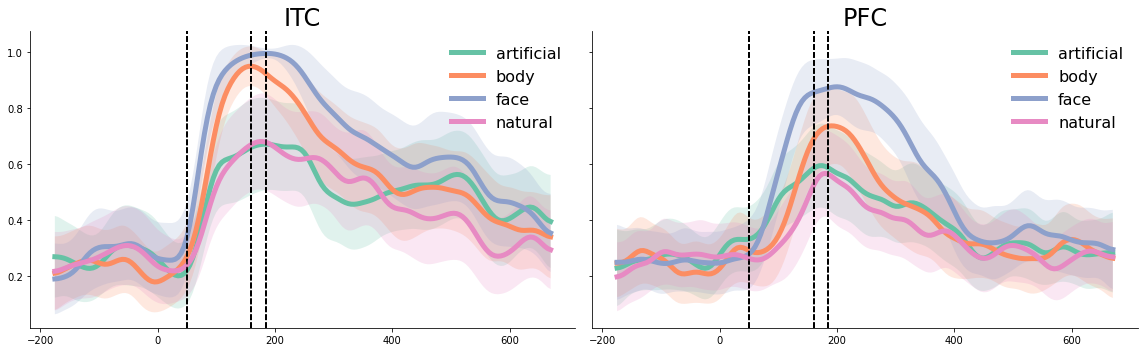

In [78]:
%matplotlib inline
plt.ion()

monkey = "both"
selectivity = "fast"
out_path  = f'G:\\Codes\\Processing\\out\\svmc\\{monkey.lower()}-{selectivity.lower()}'

import pickle
with open(f"{out_path}\\it-meta.npy", "rb") as handler:
    meta = pickle.load(handler)
itc = np.load(os.path.join(out_path, "it" + '-rec.npy'))
pfc = np.load(os.path.join(out_path, "pfc" + '-rec.npy'))

# acc = np.diagonal(cfn, axis1=0, axis2=1).sum(-1) / cfn.sum((0, 1))
# plt.plot(data.time[time_bins], np.nanmean(acc, 1))
itc = smooth(itc, 3, axis=1)
pfc = smooth(pfc, 3, axis=1)

fig, axs = plt.subplots(1, 2, figsize=(16, 5), sharey=True)

for ax, rec, reg in zip(axs, [itc, pfc], ["ITC", "PFC"]):
    for r in rec:
        ax.plot(meta['time'], r.mean(1).T, lw=5)
        ax.fill_between(meta['time'], 
                        r.mean(1) - r.std(1), 
                        r.mean(1) + r.std(1),
                        alpha=.2)
        ax.legend(meta['labels'], frameon=False, fontsize=16)
        ax.axvline(185, color='k', linestyle='--', label='_nolegend_')
        ax.axvline(50, color='k', linestyle='--', label='_nolegend_')
        ax.axvline(160, color='k', linestyle='--', label='_nolegend_')
        ax.set_title(reg, fontsize=24)

# ax.annotate(f"{int(data.time[metric.mean(1).argmax()])}, {anot:.1f}", 
#             xy=(data.time[metric.mean(1).argmax()], metric.mean(1).max()), 
#             xycoords='data', fontsize=18, 
#             horizontalalignment='center',
#             verticalalignment=va)
sns.despine()

fig.tight_layout()
plt.show()

In [68]:
1.96 * r.std(1) / r.shape[1]

200

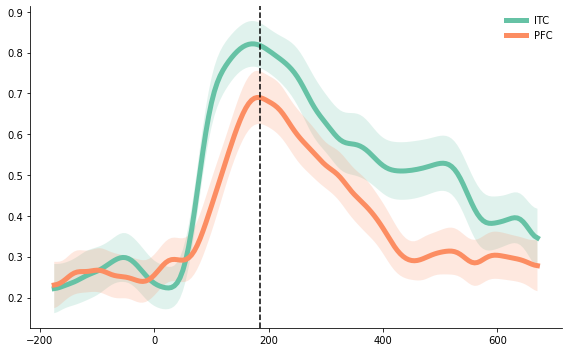

In [84]:
monkey = "both"
selectivity = "fast"
out_path  = f'G:\\Codes\\Processing\\out\\svmc\\{monkey.lower()}-{selectivity.lower()}'

import pickle
with open(f"{out_path}\\it-meta.npy", "rb") as handler:
    meta = pickle.load(handler)
itc = np.load(os.path.join(out_path, "it" + '-cfn.npy'))
pfc = np.load(os.path.join(out_path, "pfc" + '-cfn.npy'))

itc = np.diagonal(itc, axis1=0, axis2=1).sum(-1) / itc.sum((0, 1))
pfc = np.diagonal(pfc, axis1=0, axis2=1).sum(-1) / pfc.sum((0, 1))

itc = smooth(itc, 3, axis=0)
pfc = smooth(pfc, 3, axis=0)

fig, ax = plt.subplots(1, 1, figsize=(8, 5))

for reg in [itc, pfc]:
    ax.plot(meta['time'], reg.mean(1), lw=5)
    ax.fill_between(meta['time'],
                    reg.mean(1) - reg.std(1),
                    reg.mean(1) + reg.std(1),
                    alpha=.2)

# sns.barplot(x=np.tile(data.time[time_bins], 200).flatten(), y=itc.flatten(), ax=ax)
ax.legend(["ITC", "PFC"], frameon=False)
ax.axvline(185, color='k', linestyle='--', label='_nolegend_')

sns.despine()

fig.tight_layout()